Lambda School Data Science

*Unit 2, Sprint 2, Module 4*

---

# Classification Metrics

## Assignment
- [ ] If you haven't yet, [review requirements for your portfolio project](https://lambdaschool.github.io/ds/unit2), then submit your dataset.
- [ ] Plot a confusion matrix for your Tanzania Waterpumps model.
- [ ] Continue to participate in our Kaggle challenge. Every student should have made at least one submission that scores at least 70% accuracy (well above the majority class baseline).
- [ ] Submit your final predictions to our Kaggle competition. Optionally, go to **My Submissions**, and _"you may select up to 1 submission to be used to count towards your final leaderboard score."_
- [ ] Commit your notebook to your fork of the GitHub repo.
- [ ] Read [Maximizing Scarce Maintenance Resources with Data: Applying predictive modeling, precision at k, and clustering to optimize impact](https://towardsdatascience.com/maximizing-scarce-maintenance-resources-with-data-8f3491133050), by Lambda DS3 student Michael Brady. His blog post extends the Tanzania Waterpumps scenario, far beyond what's in the lecture notebook.


## Stretch Goals

### Reading

- [Attacking discrimination with smarter machine learning](https://research.google.com/bigpicture/attacking-discrimination-in-ml/), by Google Research, with  interactive visualizations. _"A threshold classifier essentially makes a yes/no decision, putting things in one category or another. We look at how these classifiers work, ways they can potentially be unfair, and how you might turn an unfair classifier into a fairer one. As an illustrative example, we focus on loan granting scenarios where a bank may grant or deny a loan based on a single, automatically computed number such as a credit score."_
- [Notebook about how to calculate expected value from a confusion matrix by treating it as a cost-benefit matrix](https://github.com/podopie/DAT18NYC/blob/master/classes/13-expected_value_cost_benefit_analysis.ipynb)
- [Visualizing Machine Learning Thresholds to Make Better Business Decisions](https://blog.insightdatascience.com/visualizing-machine-learning-thresholds-to-make-better-business-decisions-4ab07f823415)


### Doing
- [ ] Share visualizations in our Slack channel!
- [ ] RandomizedSearchCV / GridSearchCV, for model selection. (See module 3 assignment notebook)
- [ ] Stacking Ensemble. (See module 3 assignment notebook)
- [ ] More Categorical Encoding. (See module 2 assignment notebook)

In [1]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [2]:
import pandas as pd

# Merge train_features.csv & train_labels.csv
train = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv'), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv'))

# Read test_features.csv & sample_submission.csv
test = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv')
sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')

In [3]:
# Split train into train and validation
from sklearn.model_selection import train_test_split

train, val = train_test_split(train, train_size=0.80, test_size=0.20,
                              stratify=train['status_group'], random_state=42)

train.shape, val.shape, test.shape

((47520, 41), (11880, 41), (14358, 40))

In [4]:
import category_encoders as ce
import numpy as np

# Wrangle function that cleans the data
def wrangle(X):
    X = X.copy()
    
    X['latitude'] = X['latitude'].replace(-2e-08, 0)
    
    cols_with_zeros = ['longitude', 'latitude', 'construction_year', 'gps_height', 'population']
    
    for col in cols_with_zeros:
        X[col] = X[col].replace(0, np.NaN)
        X[col + '_MISSING'] = X[col].isnull()
    
    duplicates = ['quantity_group', 'payment_type', 'source_type', 'waterpoint_type_group', 
                  'extraction_type_group', 'amount_tsh', 'wpt_name', 'num_private', 'region_code']
    X = X.drop(columns=duplicates)
    
    unusable_variance = ['recorded_by', 'id']
    X = X.drop(columns=unusable_variance)
    
    X['date_recorded'] = pd.to_datetime(X['date_recorded'], infer_datetime_format=True)
    
    X['year_recorded'] = X['date_recorded'].dt.year
    X['month_recorded'] = X['date_recorded'].dt.month
    X['day_recorded'] = X['date_recorded'].dt.day
    X = X.drop(columns='date_recorded')
    
    X['years'] = X['year_recorded']- X['construction_year']
    X['years_MISSING'] = X['years'].isnull()
    
    # One hot encoding DOES NOT improve the accuracy of validation

#    encode = ce.OneHotEncoder(use_cat_names=True)
    
#    cardinality = X.select_dtypes(exclude='number').nunique()

#    categorical_features = cardinality[cardinality <= 10.index.tolist()
    
#    for col in categorical_features:
#        if col != 'status_group':
#            test123 = np.array(X[col])
#            X[col] = encode.fit_transform(test123)
    return X

train = wrangle(train)
val = wrangle(val)
test = wrangle(test)

In [5]:
# Set x and y variables
target = 'status_group'

#X_train = pd.concat([train, val], axis=0)
#X_train = X_train.drop(columns=target)
X_train = train.drop(columns=target)

X_val  = val.drop(columns=target)
X_test = test

#y_train = pd.concat([train, val], axis=0)
#y_train = y_train[target]
y_train = train[target]
y_val = val[target]

In [7]:
# No idea if this output will save
# Output if you one hot encode any series <= 50
# Validation Accuracy:0.7156565656565657
import category_encoders as ce
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline

pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(strategy='median'),
    RandomForestClassifier(random_state=42, n_jobs=-1, n_estimators=350, max_depth=25, min_samples_split=4)
    
)

pipeline.fit(X_train, y_train)
score = pipeline.score(X_train, y_train)
score1 = pipeline.score(X_val, y_val)

print(f'Training Accuracy:{score}')
print(f'Validation Accuracy:{score1}')

Training Accuracy:0.9670454545454545
Validation Accuracy:0.8177609427609428


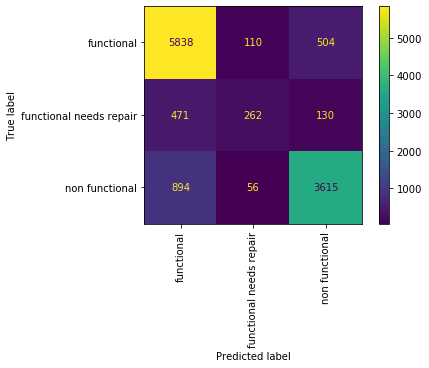

In [9]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(pipeline, X_val, y_val, values_format='d', xticks_rotation='vertical')